# Tutorial on self-normalizing networks on the MNIST data set: multi-layer perceptrons

*Author:* Kajetan Schweighofer, 2021

In [1]:
import os
import numpy as np
from tqdm.autonotebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from utils.act_fn import MLP

device = "cuda" if torch.cuda.is_available() else "cpu"



/tmp/ipykernel_379298/835469766.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# # load data and preprocess

# path = os.path.join(".", "dataset", "mnist")
# os.makedirs(path, exist_ok=True)

# # convert PIL image to tensor and normalize
# transform = transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
# test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)

## Functions

### Model

### Accuracy metric

In [3]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [4]:
class MNIST_Experiment:

    def __init__(self, batch_size: int = 128, num_workers: int = 4):

        self.batch_size = batch_size
        self.num_workers = num_workers 
        
        path = os.path.join(".", "dataset", "mnist")
        os.makedirs(path, exist_ok=True)

        # convert PIL image to tensor and normalize
        transform = transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        self.train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
        self.test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)
        rng = np.random.default_rng(seed=42)
        val_inds = rng.choice(np.arange(len(self.train)), size=len(self.train)//6, replace=False)
        train_inds = np.delete(np.arange(len(self.train)), val_inds)

        self.trainloader = DataLoader(Subset(self.train, indices=train_inds),
                                batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
        self.valloader = DataLoader(Subset(self.train, indices=val_inds),
                            batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
        self.testloader = DataLoader(self.test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)



    def _forward(self, network: nn.Module, data: DataLoader, metric: callable):

        for x, y in data:
            x = x.to(next(network.parameters()).device)
            # y_hat = network.forward(x)
            y_hat = network.forward(x).cpu()
            loss = metric(y_hat, y)
            yield loss

    @torch.enable_grad()
    def update(self, network: nn.Module, data: DataLoader, loss: nn.Module,
            opt: torch.optim.Optimizer) -> list:

        network.train()

        errs = []
        for err in self._forward(network, data, loss):
            errs.append(err.item())
            opt.zero_grad()
            try:
                err.backward()
                opt.step()
            except:
                print('error in update step')
        return errs

    @torch.no_grad()
    def evaluate(self, network: nn.Module, data: DataLoader, metric: callable) -> float:

        network.eval()

        performance = []
        for p in self._forward(network, data, metric):
            p = np.array(p)
            performance.append(p.item())
        return np.mean(performance).item()


    def fit(self, network: nn.Module, epochs: int, lr: float):
        optimizer = torch.optim.SGD(params=network.parameters(), lr=lr, weight_decay=1e-2)
        # optimizer = torch.optim.AdamW(params=network.parameters(), lr=lr, weight_decay=1e-3)
        ce = nn.CrossEntropyLoss()
        accuracy = Accuracy()

        train_losses, val_losses, accuracies = [], [], []

        # performance before training
        val_losses.append(self.evaluate(network=network, data=self.valloader, metric=ce))

        pbar = tqdm(range(epochs))
        for ep in pbar:
            # update network
            tl = self.update(network=network, data=self.trainloader, loss=ce, opt=optimizer)
            train_losses.extend(tl)
            vl = self.evaluate(network=network, data=self.valloader, metric=ce)
            val_losses.append(vl)
            ac = self.evaluate(network=network, data=self.valloader, metric=accuracy)

            if len(accuracies) == 0 or ac > max(accuracies):
                # here we would store the model on disc for early stopping
                # best_model = copy.deepcopy(network)
                best_model = network

            accuracies.append(ac)

            tqdm.write(
                f"Epoch {ep+1}: "
                f"train loss: {round(np.mean(tl), 4):.4f}, "
                f"val loss: {round(vl, 4):.4f}, "
                f"accuracy: {round(ac * 100, 2):.2f}%"
            )
            # print(f"train loss: {round(np.mean(tl), 4):.4f}, "
            #       f"val loss: {round(vl, 4):.4f}, "
            #       f"accuracy: {round(ac * 100, 2):.2f}%")

            pbar.set_description_str(desc=f"Epoch {ep+1}")

        # evaluate on best model obtained throughout training
        acc = self.evaluate(network=best_model, data=self.testloader, metric=accuracy)

        print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

        return [train_losses, val_losses, accuracies, acc]

## Training

### Hyperparameters

In [5]:
epochs = 20
# lr = 1e-3
lr = 1e-1
batch_size = 128
num_workers = 4
p_drop = 0.2

all_results = []

### Create Dataloaders

In [6]:
# # obtain validation set (1/6 of train data to be equal to size of test data)
# rng = np.random.default_rng(seed=42)
# val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
# train_inds = np.delete(np.arange(len(train)), val_inds)

# trainloader = DataLoader(Subset(train, indices=train_inds),
#                          batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
# valloader = DataLoader(Subset(train, indices=val_inds),
#                        batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
# testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [7]:
# exp training
exp_list = ["reu", "relu"]

for exp_name in exp_list:
    network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn=exp_name, use_dropout=True, use_layernorm=True, use_sparse=False)
    network = network.to(device)
    exp = MNIST_Experiment(batch_size=batch_size, num_workers=num_workers)
    exp_results = exp.fit(network, epochs, lr)
    exp_results.append(exp_name.upper())
    all_results.append(exp_results)

# # network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="linear").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu", use_dropout=True, use_layernorm=True, use_sparse=False)
# network = network.to(device)
# exp = MNIST_Experiment(batch_size=batch_size, num_workers=num_workers)
# reu_results = exp.fit(network, epochs, lr)
# reu_results.append("REU")
# all_results.append(reu_results)

Epoch 1:   5%|▌         | 1/20 [00:01<00:29,  1.56s/it]

Epoch 1: train loss: 0.5625, val loss: 0.4132, accuracy: 94.82%


Epoch 2:  10%|█         | 2/20 [00:03<00:27,  1.52s/it]

Epoch 2: train loss: 0.4307, val loss: 0.4107, accuracy: 94.71%


Epoch 3:  15%|█▌        | 3/20 [00:04<00:25,  1.51s/it]

Epoch 3: train loss: 0.4129, val loss: 0.3925, accuracy: 95.62%


Epoch 4:  20%|██        | 4/20 [00:06<00:24,  1.53s/it]

Epoch 4: train loss: 0.4060, val loss: 0.3862, accuracy: 95.76%


Epoch 5:  25%|██▌       | 5/20 [00:07<00:22,  1.53s/it]

Epoch 5: train loss: 0.4008, val loss: 0.4001, accuracy: 95.43%


Epoch 6:  30%|███       | 6/20 [00:09<00:21,  1.53s/it]

Epoch 6: train loss: 0.3989, val loss: 0.3734, accuracy: 96.39%


Epoch 7:  35%|███▌      | 7/20 [00:10<00:19,  1.53s/it]

Epoch 7: train loss: 0.3947, val loss: 0.3745, accuracy: 96.37%


Epoch 8:  40%|████      | 8/20 [00:12<00:18,  1.53s/it]

Epoch 8: train loss: 0.3927, val loss: 0.3795, accuracy: 96.09%


Epoch 9:  45%|████▌     | 9/20 [00:13<00:16,  1.54s/it]

Epoch 9: train loss: 0.3938, val loss: 0.3729, accuracy: 96.34%


Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.54s/it]

Epoch 10: train loss: 0.3931, val loss: 0.4767, accuracy: 92.07%


Epoch 11:  55%|█████▌    | 11/20 [00:16<00:13,  1.53s/it]

Epoch 11: train loss: 0.3898, val loss: 0.3774, accuracy: 96.13%


Epoch 12:  60%|██████    | 12/20 [00:18<00:12,  1.53s/it]

Epoch 12: train loss: 0.3917, val loss: 0.3791, accuracy: 96.01%


Epoch 13:  65%|██████▌   | 13/20 [00:19<00:10,  1.53s/it]

Epoch 13: train loss: 0.3930, val loss: 0.3950, accuracy: 95.52%


Epoch 14:  70%|███████   | 14/20 [00:21<00:09,  1.54s/it]

Epoch 14: train loss: 0.3939, val loss: 0.3890, accuracy: 95.89%


Epoch 15:  75%|███████▌  | 15/20 [00:22<00:07,  1.54s/it]

Epoch 15: train loss: 0.3947, val loss: 0.3755, accuracy: 96.15%


Epoch 16:  80%|████████  | 16/20 [00:24<00:06,  1.53s/it]

Epoch 16: train loss: 0.3888, val loss: 0.3862, accuracy: 95.76%


Epoch 17:  85%|████████▌ | 17/20 [00:26<00:04,  1.53s/it]

Epoch 17: train loss: 0.3910, val loss: 0.3815, accuracy: 96.00%


Epoch 18:  90%|█████████ | 18/20 [00:27<00:03,  1.54s/it]

Epoch 18: train loss: 0.3867, val loss: 0.3726, accuracy: 96.31%


Epoch 19:  95%|█████████▌| 19/20 [00:29<00:01,  1.53s/it]

Epoch 19: train loss: 0.3901, val loss: 0.3666, accuracy: 96.70%


Epoch 20: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]

Epoch 20: train loss: 0.3885, val loss: 0.3779, accuracy: 95.98%


Final accuracy on testset: 96.46%


Epoch 1:   5%|▌         | 1/20 [00:01<00:29,  1.53s/it]

Epoch 1: train loss: 0.5785, val loss: 0.4321, accuracy: 94.95%


Epoch 2:  10%|█         | 2/20 [00:03<00:27,  1.55s/it]

Epoch 2: train loss: 0.4460, val loss: 0.4076, accuracy: 95.68%


Epoch 3:  15%|█▌        | 3/20 [00:04<00:26,  1.55s/it]

Epoch 3: train loss: 0.4249, val loss: 0.4553, accuracy: 93.19%


Epoch 4:  20%|██        | 4/20 [00:06<00:24,  1.55s/it]

Epoch 4: train loss: 0.4180, val loss: 0.3895, accuracy: 95.72%


Epoch 5:  25%|██▌       | 5/20 [00:07<00:23,  1.55s/it]

Epoch 5: train loss: 0.4127, val loss: 0.3862, accuracy: 96.23%


Epoch 6:  30%|███       | 6/20 [00:09<00:21,  1.54s/it]

Epoch 6: train loss: 0.4064, val loss: 0.3807, accuracy: 96.23%


Epoch 7:  35%|███▌      | 7/20 [00:10<00:20,  1.54s/it]

Epoch 7: train loss: 0.4045, val loss: 0.3785, accuracy: 96.27%


Epoch 8:  40%|████      | 8/20 [00:12<00:18,  1.54s/it]

Epoch 8: train loss: 0.4055, val loss: 0.3939, accuracy: 95.79%


Epoch 9:  45%|████▌     | 9/20 [00:13<00:16,  1.54s/it]

Epoch 9: train loss: 0.4063, val loss: 0.3672, accuracy: 96.51%


Epoch 10:  50%|█████     | 10/20 [00:15<00:15,  1.54s/it]

Epoch 10: train loss: 0.4053, val loss: 0.4404, accuracy: 94.26%


Epoch 11:  55%|█████▌    | 11/20 [00:16<00:13,  1.54s/it]

Epoch 11: train loss: 0.4003, val loss: 0.3921, accuracy: 95.85%


Epoch 12:  60%|██████    | 12/20 [00:18<00:12,  1.54s/it]

Epoch 12: train loss: 0.4067, val loss: 0.3708, accuracy: 96.49%


Epoch 13:  65%|██████▌   | 13/20 [00:20<00:10,  1.54s/it]

Epoch 13: train loss: 0.4015, val loss: 0.3710, accuracy: 96.65%


Epoch 14:  70%|███████   | 14/20 [00:21<00:09,  1.53s/it]

Epoch 14: train loss: 0.4036, val loss: 0.4064, accuracy: 95.19%


Epoch 15:  75%|███████▌  | 15/20 [00:23<00:07,  1.53s/it]

Epoch 15: train loss: 0.4002, val loss: 0.4147, accuracy: 95.22%


Epoch 16:  80%|████████  | 16/20 [00:24<00:06,  1.52s/it]

Epoch 16: train loss: 0.4101, val loss: 0.4484, accuracy: 94.15%


Epoch 17:  85%|████████▌ | 17/20 [00:26<00:04,  1.53s/it]

Epoch 17: train loss: 0.3997, val loss: 0.3910, accuracy: 95.95%


Epoch 18:  90%|█████████ | 18/20 [00:27<00:03,  1.53s/it]

Epoch 18: train loss: 0.4030, val loss: 0.3872, accuracy: 96.10%


Epoch 19:  95%|█████████▌| 19/20 [00:29<00:01,  1.53s/it]

Epoch 19: train loss: 0.4022, val loss: 0.4037, accuracy: 95.22%


Epoch 20: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Epoch 20: train loss: 0.4018, val loss: 0.4788, accuracy: 93.15%


Final accuracy on testset: 93.50%


In [8]:




# network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="square").to(device)
# LN_tl, LN_vl, LN_accs, LN_acc = fit(network, trainloader, valloader, testloader, epochs, lr)
# ReLU training

# 28x28 = 784 input images for 10 classes
# network = LN_MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
# rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

# # SELU training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="selu").to(device)
# stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

# # ELU training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="elu").to(device)
# elutl, eluvl, eluaccs, eluacc = fit(network, trainloader, valloader, testloader, epochs, lr)

# # exp training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# softtl, softvl, softaccs, softacc = fit(network, trainloader, valloader, testloader, epochs, lr)

# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)


### Plot results

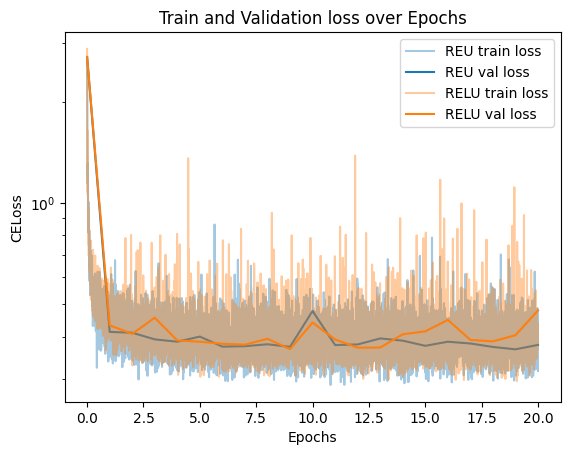

In [9]:
plt.figure()

for i in range(len(all_results)):
    tl, vl, accs, acc, name = all_results[i]
    plt.plot(np.asarray(range(len(tl))) / len(exp.trainloader), tl, alpha=0.4, label=f"{name} train loss")
    plt.plot(range(len(vl)), vl, label=f"{name} val loss", color=f"C{i}")
    
# plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
# plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
# plt.plot(np.asarray(range(len(LN_tl))) / len(trainloader), LN_tl, alpha=0.4, label="LayerNorm Exp train loss")
# plt.plot(range(len(LN_vl)), LN_vl, color="C1", label="LayerNorm Exp val loss")
# plt.plot(np.asarray(range(len(llt))) / len(trainloader), llt, alpha=0.4, label="Exp Reg train loss")
# plt.plot(range(len(llvl)), llvl, color="C2", label="Exp Reg val loss")
# # plt.plot(np.asarray(range(len(softtl))) / len(trainloader), softtl, alpha=0.4, label="Exp train loss")
# # plt.plot(range(len(softvl)), softvl, color="C2", label="Exp val loss")
# # plt.plot(np.asarray(range(len(elutl))) / len(trainloader), elutl, alpha=0.4, label="ELU train loss")
# # plt.plot(range(len(eluvl)), eluvl, color="C3", label="ELU val loss")
# # plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
# # plt.plot(range(len(svl)), svl, color="C4", label="SELU val loss")


plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

In [10]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(LN_accs)+1), [a*100 for a in LN_accs], label="LayerNorm val accuracy")
plt.hlines(y=LN_acc*100, xmin=0, xmax=len(LN_accs), colors="C1", linestyles="dashed", label="LayerNorm test accuracy")
plt.plot(range(1, len(llaccs)+1), [a*100 for a in llaccs], label="Linear val accuracy")
plt.hlines(y=llacc*100, xmin=0, xmax=len(llaccs), colors="C2", linestyles="dashed", label="Linear test accuracy")
# plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
# plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
# plt.plot(range(1, len(softaccs)+1), [a*100 for a in softaccs], label="Exp val accuracy")
# plt.hlines(y=softacc*100, xmin=0, xmax=len(softaccs), colors="C2", linestyles="dashed", label="Exp test accuracy")
# plt.plot(range(1, len(eluaccs)+1), [a*100 for a in eluaccs], label="ELU val accuracy")
# plt.hlines(y=eluacc*100, xmin=0, xmax=len(eluaccs), colors="C3", linestyles="dashed", label="ELU test accuracy")

plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(80, 100)
plt.legend()
plt.show()

NameError: name 'raccs' is not defined

<Figure size 640x480 with 0 Axes>